# Implementation of stance detection problem using Glove vectorization and baseline model

In [2]:
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
import re
import numpy as np
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import pandas as pd
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score
import nltk
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings("ignore")

In [4]:
def labelStance(labelDict, data):
	for key, val in labelDict.items():
		data.loc[data["Stance"] == val, "Stance"] = int(key)
	return data

def readGlobalVecData(glove_word_vec_file):
	file = open(glove_word_vec_file, encoding="utf8")
	rawData = file.readlines()
	glove_word_vec_dict = {}
	for line in rawData:
		line = line.strip().split()
		tag = line[0]
		vec = line[1:]
		glove_word_vec_dict[tag] = np.array(vec, dtype=float)
	return glove_word_vec_dict

gloveFile = "H:\Project Files\Glove Data\glove.twitter.27B.200d.txt"

print("\nLoading Glove data in progress...")
glove_word_vec_dict = readGlobalVecData(gloveFile)
print("\nLoading Glove data is done...")


Loading Glove data in progress...

Loading Glove data is done...


In [32]:
classifiers = ['Support Vector Machine', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'Logistic Regression', 'Neural Network', 'Gaussian NB', 'K Neighbors Classifier', 'Decision Tree Classifier']

training = "H:\Project Files\stance-detection\Dataset-Demonitization\csv_files/demoapril.csv"

Tweets = pd.read_csv(training,encoding='utf-8')
Tweets = Tweets.fillna(5)    

#For converting all the stances into numerical values in both training and test data
labelDict = {0:"A", 1:"F", 2:"N"}
Tweets = labelStance(labelDict, Tweets)
print('Shape of label tensor:', Tweets.shape)


Shape of label tensor: (1999, 3)


In [26]:
def getWordVector(word, glove_word_vec_dict):
	if word in glove_word_vec_dict:
		return glove_word_vec_dict[word]
	return np.zeros_like(glove_word_vec_dict["dummy"])

In [27]:
def sumVectors(finalList, glove_word_vec_dict):
	numNonZero = 0
	vector = np.zeros_like(glove_word_vec_dict["dummy"])
	for word in finalList:
		vect = getWordVector(word,glove_word_vec_dict)
		if vect.sum() != 0:
			vector += vect
			numNonZero += 1
	if numNonZero:
		vector = vector/numNonZero
	return vector

In [28]:
def sumVectorsCNN(finalList, glove_word_vec_dict):
	numNonZero = 0
	vector = []
	for word in finalList:
		vector.append(getWordVector(word,glove_word_vec_dict))
	return vector

In [29]:
def simplify(word):
	dump = ''
	temp = []
	listOfWords = list(filter(None,re.split("([A-Z][^A-Z]*)",word)))
	if len(listOfWords) == len(word):
		return word.lower()
	for i in range(len(listOfWords)):
		listOfWords[i] = listOfWords[i].lower()
		if len(listOfWords[i]) == 1:
			dump = dump + listOfWords[i]
			if dump in words.words() and len(dump) > 2:
				temp.append(dump)
				dump = ''
		else:
			temp.append(listOfWords[i])
	return temp

In [30]:
def glove(glove_word_vec_dict, trainTweets):
    def createTokens(data,glove_word_vec_dict):
        listOfTweets = []
        listOfStances = []
        tweetVector = []
        for ind, row in data.iterrows():
            # Create a sentence using target and the tweet. Word vector will be formed from this.
            example_sentence = 'Demonitization' +' ' + str(row["text"])
            # Remove punctuation
            final_sentence = example_sentence.translate(string.punctuation)
            wordList = word_tokenize(final_sentence)
            finalList = []
            s = ' '.join([i for i in wordList if i.isalpha()])
            # create tokens from the string and stem them
            wordList = word_tokenize(s)
            wordList = [w.lower() for w in wordList]
            stop_words = set(stopwords.words('english'))
            wordList = [w for w in wordList if not w in stop_words]
            for word in wordList:
                #to break any combined word into its components for eg, hashtags
                finalList += simplify(word)
            final_sentence = ' '.join(finalList)
            listOfTweets.append(final_sentence)
            listOfStances.append(row["Stance"])
            tweetVector.append(sumVectors(finalList,glove_word_vec_dict))
        return listOfTweets, listOfStances, tweetVector
    # Remove punctuation from and tokenize the tweets
    listOfTweets, listOfStances, trainTweetVector = createTokens(trainTweets, glove_word_vec_dict)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(trainTweetVector,listOfStances, test_size = 0.1, random_state = 42)

    Xtrain = np.asarray(X_train)
    Ytrain = np.asarray(Y_train)
    Xtest = np.asarray(X_test)
    Ytest = np.asarray(Y_test)
    return Xtrain, Ytrain, Xtest, Ytest

In [33]:
totalAcc = []
for classifier in classifiers:
    print("\nThe Machine Learning Model Used For Classification : " + classifier)
    temp = []
    
    Xtrain, Ytrain, Xtest, Ytest = glove(glove_word_vec_dict,Tweets)


    if classifier == 'Support Vector Machine':
      clf = SVC(kernel="rbf").fit(Xtrain, Ytrain)

    elif classifier == 'Random Forest Classifier':
      clf = RandomForestClassifier(n_estimators=90).fit(Xtrain, Ytrain)

    elif classifier == 'Gradient Boosting Classifier':
      clf = GradientBoostingClassifier().fit(Xtrain, Ytrain)

    elif classifier == 'Logistic Regression':
      clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(Xtrain, Ytrain)

    elif classifier == 'Neural Network':
      clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(Xtrain, Ytrain)

    elif classifier == 'Gaussian NB':
      clf = GaussianNB().fit(Xtrain, Ytrain)

    elif classifier == 'K Neighbors Classifier':
      clf = GaussianNB().fit(Xtrain, Ytrain)

    elif classifier == 'Decision Tree Classifier':
      clf = tree.DecisionTreeClassifier().fit(Xtrain, Ytrain)

    acc = clf.score(Xtest, Ytest)
    
    print("Total Test Accuracy is "+ str(round(acc*100,2)) +"%")
    totalAcc.append(acc)


The Machine Learning Model Used For Classification : Support Vector Machine
Total Test Accuracy is 49.5%

The Machine Learning Model Used For Classification : Random Forest Classifier
Total Test Accuracy is 58.5%

The Machine Learning Model Used For Classification : Gradient Boosting Classifier
Total Test Accuracy is 62.0%

The Machine Learning Model Used For Classification : Logistic Regression
Total Test Accuracy is 60.0%

The Machine Learning Model Used For Classification : Neural Network
Total Test Accuracy is 53.5%

The Machine Learning Model Used For Classification : Gaussian NB
Total Test Accuracy is 52.5%

The Machine Learning Model Used For Classification : K Neighbors Classifier
Total Test Accuracy is 52.5%

The Machine Learning Model Used For Classification : Decision Tree Classifier
Total Test Accuracy is 47.0%


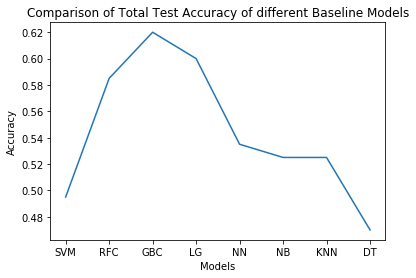

In [35]:
import matplotlib.pyplot as plt

x  = ['SVM', 'RFC', 'GBC', 'LG', 'NN', 'NB', 'KNN', 'DT']
y  = totalAcc

plt.plot(x, y)
plt.plot()

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Total Test Accuracy of different Baseline Models")
plt.show()